In [9]:
import numpy as np
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
data = pd.read_csv("tweets.csv")
data.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [4]:
data.text[0]

'Communal violence in Bhainsa, Telangana. "Stones were pelted on Muslims\' houses and some houses and vehicles were set ablaze…'

In [5]:
data.shape

(11370, 5)

# EDA

## 1. Number of caracteres in tweets

In [6]:
data["numberOfcaractere"] = data.text.str.len()

<AxesSubplot:>

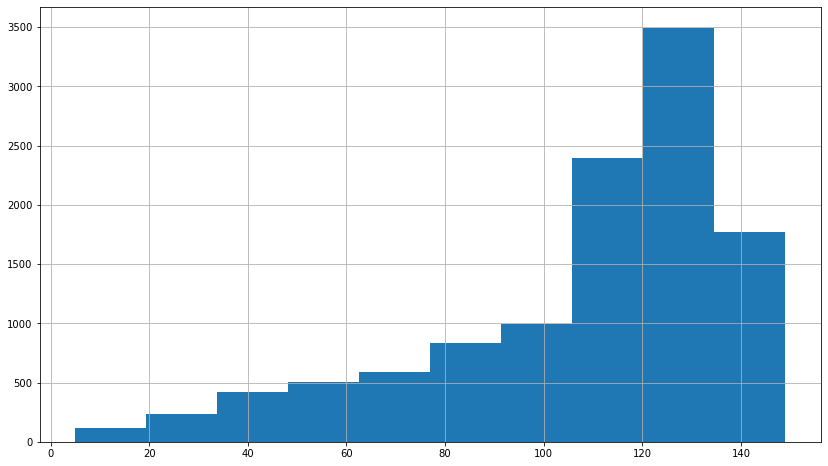

In [7]:
data.numberOfcaractere.hist(figsize=(14,8))

<AxesSubplot:xlabel='numberOfcaractere', ylabel='Count'>

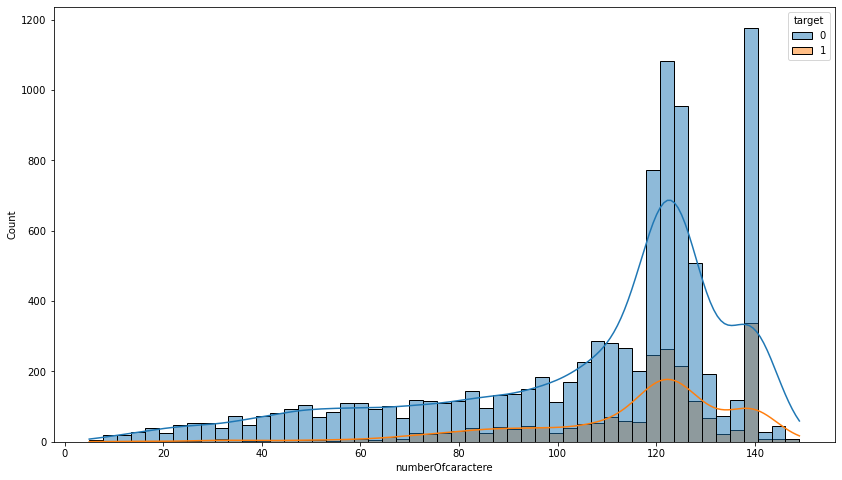

In [10]:
plt.figure(figsize=(14,8))
sns.histplot(x="numberOfcaractere", data=data, hue="target", kde=True)

### Remarques:
- le nombre de caracteres dans les phrases est entre 20 - 140
- les tweets qui font reference a un desastre on souvant un nombre de caractere comprise entre 100 et 130

## 2. Number of words

In [11]:
data["numberOfWords"] = data.text.str.split().map(lambda x: len(x))
#data.text.str.split().map( lambda x : len(x)).hist(figsize=(14,8))

<AxesSubplot:xlabel='numberOfWords', ylabel='Count'>

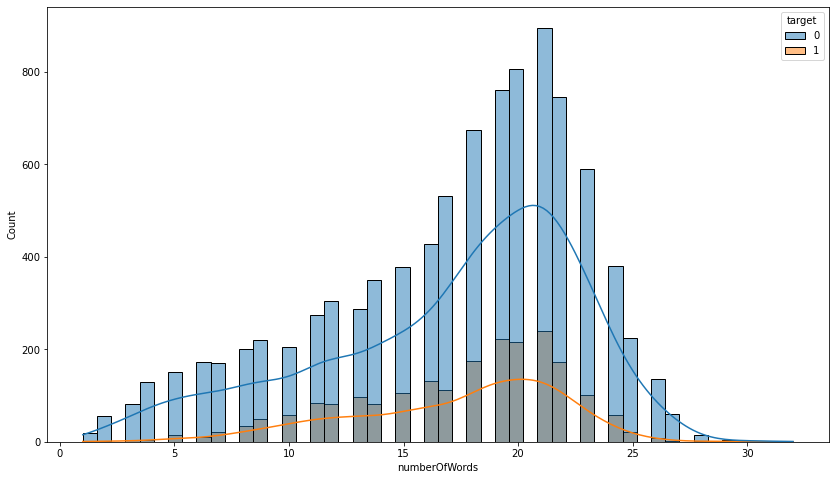

In [12]:
plt.figure(figsize=(14,8))
sns.histplot(x="numberOfWords", data=data, hue="target", kde=True)

### Remarques:
- le nombre de mots dans les tweets sont entres 3 et 30, mais generalement au tour de 15-25

## 3. Location

In [17]:
data.location.value_counts()

United States                   96
Australia                       83
London, England                 81
UK                              77
India                           74
                                ..
Newlands, South Africa           1
Brunswick, Melbourne             1
Youhr Mahms, VA                  1
Doesn'tLikeRankingOT7ForReal     1
Corpus Christi, Texas, US        1
Name: location, Length: 4504, dtype: int64

In [21]:
data.location.isnull().value_counts()

False    7952
True     3418
Name: location, dtype: int64

In [ ]:
,

## 3. Target

<AxesSubplot:xlabel='target', ylabel='count'>

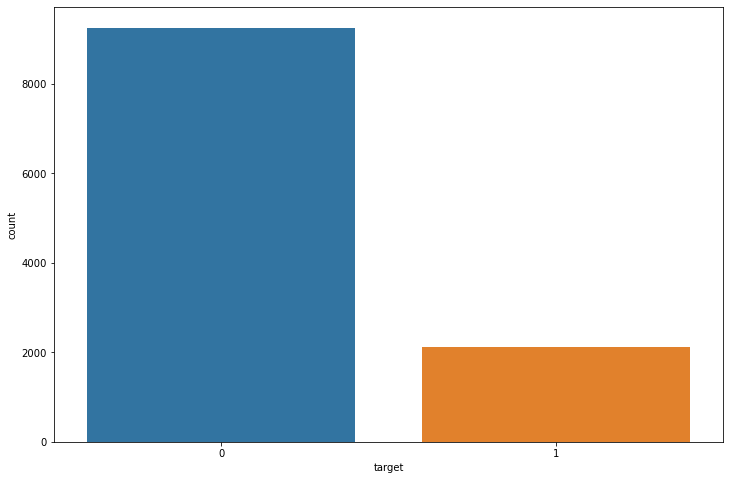

In [14]:
plt.figure(figsize=(12,8))
sns.countplot(x="target", data=data)

# TEXT PROCESSING

In [25]:
#preprocessing

import string
import re

def remove_url(text):
    url = re.compile(r"https?://\S+|www\.\S+")
    return url.sub(r"", text)

def remove_ablazeWord(text):
    return text.replace("ablaze", "")

def remove_punct(text):
    translator = str.maketrans("", "", string.punctuation)
    return text.translate(translator)

def remove_tripleDot(text):
    return text.replace('\u2026', "")

def remove_emojis(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [24]:
data["text"] = data.text.map(remove_url)
data["text"] = data.text.map(remove_punct)
data["text"] = data.text.map(remove_tripleDot)
data["text"] = data.text.map(remove_emojis)
data["text"] = data.text.map(remove_ablazeWord)

In [26]:
#remove stop word

from spacy.lang.en import STOP_WORDS

stopwords = set(STOP_WORDS)

nlp = spacy.load('en_core_web_sm')

def remove_stopword(text):
    filleterd_text = [word.lemma_.lower() for word in nlp.tokenizer(text) if not word.text.lower() in stopwords]
    return " ".join(filleterd_text)

In [27]:
data["text"] = data.text.map(remove_stopword)

# WORDCLOUD

In [36]:
from wordcloud import WordCloud

comment_words = ''
  
# iterate through the csv file
for val in data.text:
      
    # typecaste each val to string
    val = str(val)
  
    # split the value
    tokens = val.split()
      
    # Converts each token into lowercase
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
      
    comment_words += " ".join(tokens)+" "
  

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='black',
                min_font_size = 10,
                colormap='Set2', collocations=False).generate(comment_words)

In [37]:
def plot_word(wordcloud):
    plt.figure(figsize = (20, 10), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

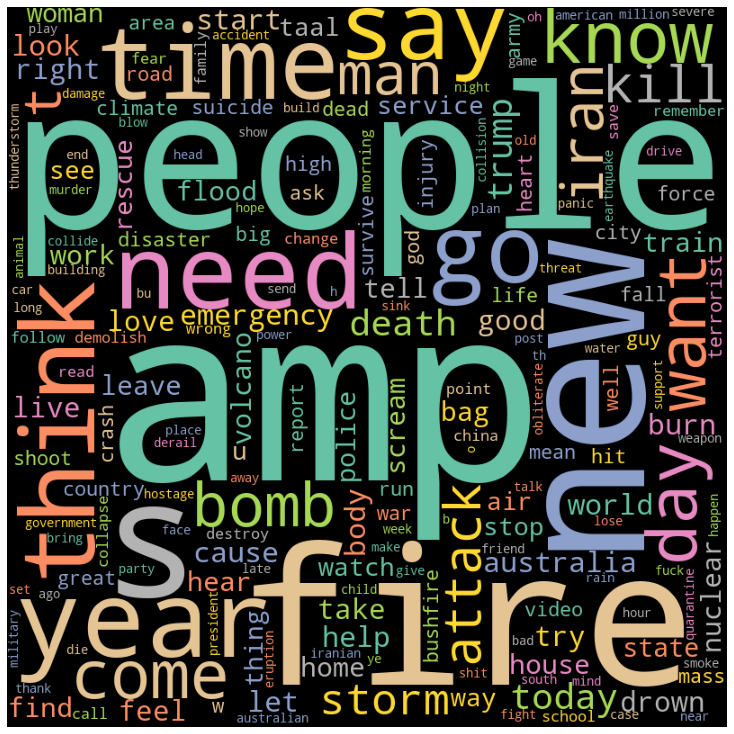

In [38]:
plot_word(wordcloud=wordcloud)

# MODEL

## 1. SVM

In [28]:
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import MultinomialNB

In [29]:
X = data.text
y = data["target"]

In [36]:
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_df=0.9, min_df=10)
tfidf_matrix = tfidf_vectorizer.fit_transform(X)
dense = tfidf_matrix.todense()
dense.shape

(11370, 1790)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [47]:
svm = make_pipeline(TfidfVectorizer(ngram_range=(1, 2)),TfidfTransformer(), SVC(kernel="linear", gamma="auto", C=2, random_state=0))

In [42]:
def evaluate(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(confusion_matrix(y_true=y_test, y_pred=y_pred))
    print(classification_report(y_true=y_test, y_pred=y_pred))

    # N, train_score, val_score = learning_curve(model, X_train, y_train, cv=4)
    # plt.figure(figsize=(12,8))
    # plt.plot(N, train_score.mean(axis=1), label='train score')
    # plt.plot(N, val_score.mean(axis=1), label='validation score')
    # plt.legend()

In [48]:
evaluate(svm)

[[1767  105]
 [ 133  269]]
              precision    recall  f1-score   support

           0       0.93      0.94      0.94      1872
           1       0.72      0.67      0.69       402

    accuracy                           0.90      2274
   macro avg       0.82      0.81      0.82      2274
weighted avg       0.89      0.90      0.89      2274



## 2.Build NN for text classification

In [32]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Dropout, concatenate, Input, Embedding, SpatialDropout1D, GlobalAvgPool1D, GlobalMaxPool1D
from tensorflow.keras.models import Model

In [21]:
import os
root_logdir = os.path.join(os.curdir, 'my_log')
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()

In [26]:
max_length = 50

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(X_train)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding= padding_type, truncating=trunc_type)

test_sequences = tokenizer.texts_to_sequences(X_test)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding= padding_type, truncating=trunc_type)

In [27]:
vocab_size= len(word_index) + 1
embedding_dim = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

In [28]:
vocab_size

17749

In [29]:
train_padded = np.array(train_padded)
test_padded = np.array(test_padded)
train_labels = np.array(y_train)
test_labels = np.array(y_test)

In [30]:
print(train_padded.shape)
print(test_padded.shape)
print(train_labels.shape)

(9096, 50)
(2274, 50)
(9096,)


In [58]:
model = keras.models.Sequential([
    keras.layers.Embedding(input_dim=vocab_size,output_dim= embedding_dim, input_length=max_length),
    keras.layers.Conv1D(filters=50, kernel_size=3, activation='relu'),
    keras.layers.MaxPool1D(pool_size=2, strides=2),
    keras.layers.Flatten(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1, activation='sigmoid')
])

opt = keras.optimizers.SGD(lr=0.001, momentum=0.9)
optRm = keras.optimizers.RMSprop(lr=0.001, rho=0.9)

model.compile(loss="binary_crossentropy", optimizer=optRm, metrics=["accuracy"])

model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 50, 16)            283984    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 48, 50)            2450      
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 24, 50)            0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 1200)              0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 1200)              4800      
_________________________________________________________________
dropout_13 (Dropout)         (None, 1200)              0         
_________________________________________________________________
dense_16 (Dense)             (None, 10)               

In [59]:
history = model.fit(train_padded, train_labels, validation_split=.1, epochs=10, callbacks=[TensorBoard(run_logdir)], batch_size=32)

Epoch 1/10
256/256 [==============================] - 1s 5ms/step - loss: 0.5375 - accuracy: 0.7965 - val_loss: 0.4989 - val_accuracy: 0.7967
Epoch 2/10
256/256 [==============================] - 1s 4ms/step - loss: 0.4206 - accuracy: 0.8516 - val_loss: 0.4570 - val_accuracy: 0.7989
Epoch 3/10
256/256 [==============================] - 1s 4ms/step - loss: 0.3488 - accuracy: 0.8853 - val_loss: 0.3745 - val_accuracy: 0.8560
Epoch 4/10
256/256 [==============================] - 1s 4ms/step - loss: 0.3027 - accuracy: 0.9116 - val_loss: 0.3615 - val_accuracy: 0.8648
Epoch 5/10
256/256 [==============================] - 1s 4ms/step - loss: 0.2563 - accuracy: 0.9266 - val_loss: 0.4143 - val_accuracy: 0.8615
Epoch 6/10
256/256 [==============================] - 1s 4ms/step - loss: 0.2149 - accuracy: 0.9441 - val_loss: 0.4294 - val_accuracy: 0.8593
Epoch 7/10
256/256 [==============================] - 1s 5ms/step - loss: 0.1886 - accuracy: 0.9532 - val_loss: 0.5238 - val_accuracy: 0.8626
Epoch 

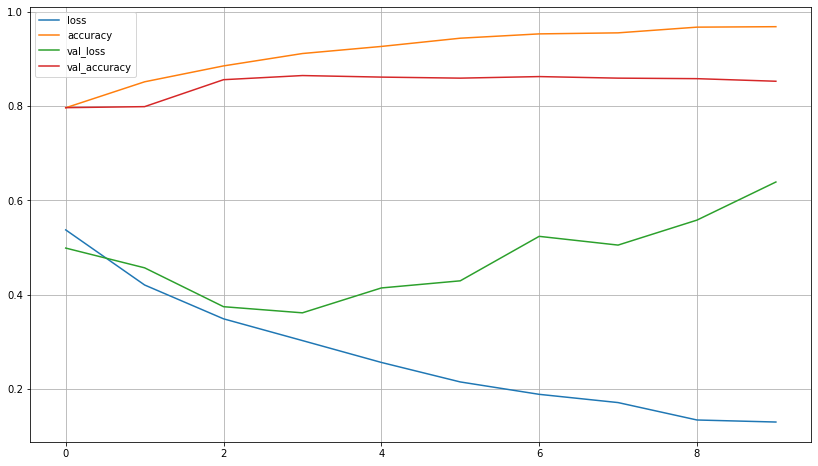

In [60]:
import matplotlib.pyplot as plt
pd.DataFrame(history.history).plot(figsize=(14,8))
plt.grid(True)

In [6]:
y_pred = model.predict_classes(test_padded)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


array([[1],
       [0],
       [1],
       [1],
       [1],
       [1]], dtype=int32)

In [42]:
print(confusion_matrix(y_true=y_test, y_pred=y_pred))
print(classification_report(y_true=y_test, y_pred=y_pred))

[[1806   66]
 [ 168  234]]
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      1872
           1       0.78      0.58      0.67       402

    accuracy                           0.90      2274
   macro avg       0.85      0.77      0.80      2274
weighted avg       0.89      0.90      0.89      2274

